In [1]:
#Step-by-Step Sales Forecasting Workflow
#Step 1: Load and Inspect the Data

import pandas as pd

df = pd.read_csv("Online_Retail_Cleaned.csv", parse_dates=["InvoiceDate"], low_memory=False)
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,IsCancellation,IsReturn,Is_Return,IsCancelled,TotalPrice,Year,Month,Day,Hour,Qty_Outlier,Price_Outlier
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,False,False,False,False,15.30,2010,12,1,8,False,False
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,False,False,False,False,20.34,2010,12,1,8,False,False
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,False,False,False,False,22.00,2010,12,1,8,False,False
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,False,False,False,False,20.34,2010,12,1,8,False,False
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,False,False,False,False,20.34,2010,12,1,8,False,False


Check for missing values, duplicates, and data types.

Confirm key columns: InvoiceDate, StockCode, Quantity, UnitPrice.

In [2]:
#Duplicates
duplicate_rows = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")


Number of duplicate rows: 0


In [3]:
#Data Types
df.dtypes


InvoiceNo                 object
StockCode                 object
Description               object
Quantity                   int64
InvoiceDate       datetime64[ns]
UnitPrice                float64
CustomerID                 int64
Country                   object
IsCancellation              bool
IsReturn                    bool
Is_Return                   bool
IsCancelled                 bool
TotalPrice               float64
Year                       int64
Month                      int64
Day                        int64
Hour                       int64
Qty_Outlier                 bool
Price_Outlier               bool
dtype: object

In [4]:
df["InvoiceNo"] = df["InvoiceNo"].astype(str)


In [5]:
df[["IsReturn", "Is_Return"]].drop_duplicates()
df[["IsCancellation", "IsCancelled"]].drop_duplicates()


,IsCancellation,IsCancelled
0,False,False


In [6]:
df = df.drop(columns=["IsCancelled", "Is_Return"])


In [7]:
df = df[(df["IsCancellation"] == False) & (df["IsReturn"] == False)]


In [8]:
#Handle Outliers in Quantity and Price
#Remove Outliers
df = df[(df["Qty_Outlier"] == False) & (df["Price_Outlier"] == False)]

#This ensures:

#No extreme quantities (e.g., bulk returns or data entry errors)

#No unrealistic prices (e.g., zero or abnormally high values)


In [9]:
df["week"] = df["InvoiceDate"].dt.to_period("W").dt.start_time


In [10]:
# Aggregate Sales Data Over Time
#To forecast sales, we need a time series. Let's aggregate TotalPrice by date:
# Aggregate daily sales
daily_sales = df.groupby(df['InvoiceDate'].dt.date)['TotalPrice'].sum()
daily_sales = daily_sales.to_frame().reset_index()
daily_sales.columns = ['Date', 'TotalSales']


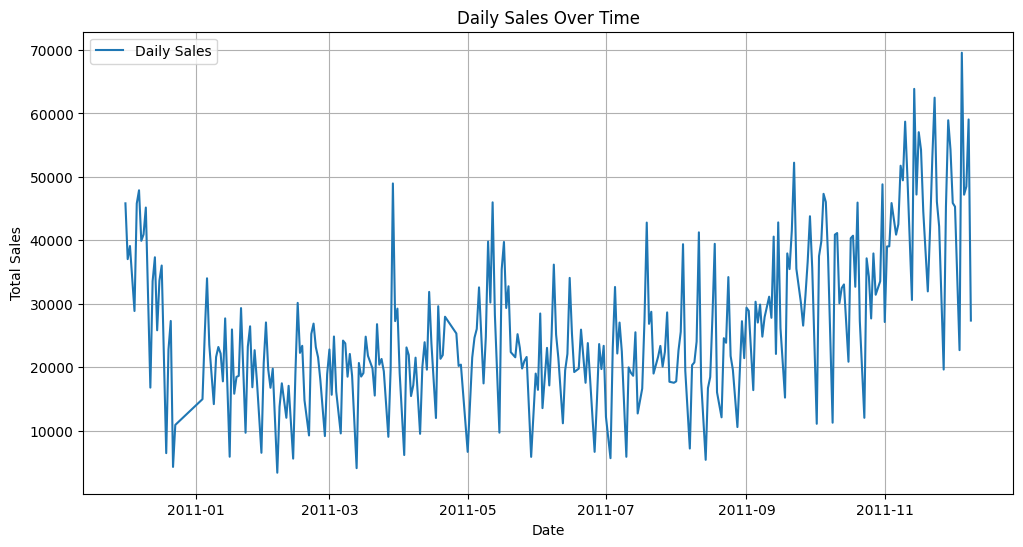

In [11]:
#Visualize the Time Series
#This helps spot trends, seasonality, or anomalies:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(daily_sales['Date'], daily_sales['TotalSales'], label='Daily Sales')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Daily Sales Over Time')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
#Aggregate Weekly 
#Aggregate Weekly Sales per SKU

weekly_sales = (
    df.groupby(["StockCode", "week"], as_index=False)
      .agg(
          Quantity=("Quantity", "sum"),
          Revenue=("UnitPrice", lambda x: (x * df.loc[x.index, "Quantity"]).sum())
      )
)


This creates a new column week based on the start of each week from InvoiceDate.

In [13]:
weekly_sales.head(10)

,StockCode,week,Quantity,Revenue
0,10002,2010-11-29,70,65.17
1,10002,2010-12-06,138,127.02
2,10002,2010-12-13,41,38.90
3,10002,2010-12-20,2,3.32
4,10002,2011-01-03,73,62.86
5,10002,2011-01-10,42,35.70
6,10002,2011-01-17,76,65.38
7,10002,2011-01-24,17,15.23
8,10002,2011-01-31,13,11.05
9,10002,2011-02-07,1,0.85


In [14]:
missing_values = df.isnull().sum()
missing_values[missing_values > 0]


Series([], dtype: int64)

aiming to predict sales (TotalPrice) based on features like Quantity, UnitPrice, Hour, Country, and possibly others,  looking at a regression problem

In [15]:
#Prepare the Features
#Let’s select relevant columns and encode categorical ones:

from sklearn.preprocessing import LabelEncoder

# Copy the dataframe to avoid modifying original
df_model = df.copy()

# Encode 'Country' as a numeric feature
le = LabelEncoder()
df_model['Country_encoded'] = le.fit_transform(df_model['Country'])

# Select features and target
features = ['Quantity', 'UnitPrice', 'Hour', 'Country_encoded']
target = 'TotalPrice'

X = df_model[features]
y = df_model[target]


In [16]:
# Week number of the year
df['Week'] = df['InvoiceDate'].dt.isocalendar().week

# Day of the week (0 = Monday, 6 = Sunday)
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek


In [17]:
features = ['Quantity', 'UnitPrice', 'Hour', 'Country_encoded', 'Week', 'DayOfWeek']


we can now visualize how sales vary by day of the week and week number. This will help you spot recurring patterns and improve your model.

C:\Users\HP\AppData\Local\Temp\ipykernel_12452\2504241349.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='DayOfWeek', y='TotalPrice', data=dow_sales, palette='viridis')


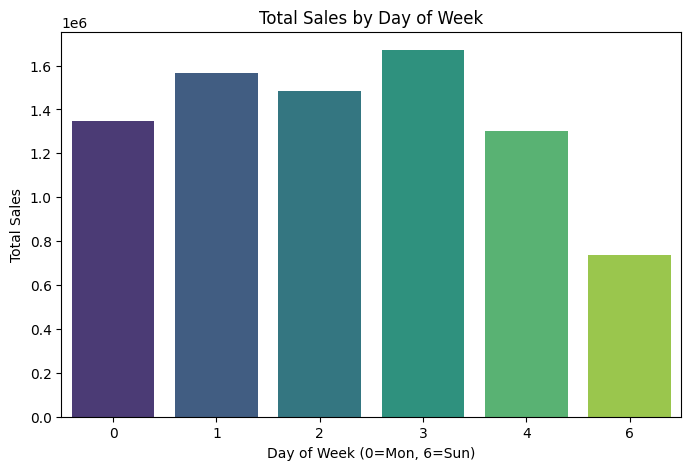

In [18]:
#Sales by Day of Week

import seaborn as sns
import matplotlib.pyplot as plt

# Add DayOfWeek column
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek

# Aggregate total sales by day of week
dow_sales = df.groupby('DayOfWeek')['TotalPrice'].sum().reset_index()

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x='DayOfWeek', y='TotalPrice', data=dow_sales, palette='viridis')
plt.title('Total Sales by Day of Week')
plt.xlabel('Day of Week (0=Mon, 6=Sun)')
plt.ylabel('Total Sales')
plt.show()


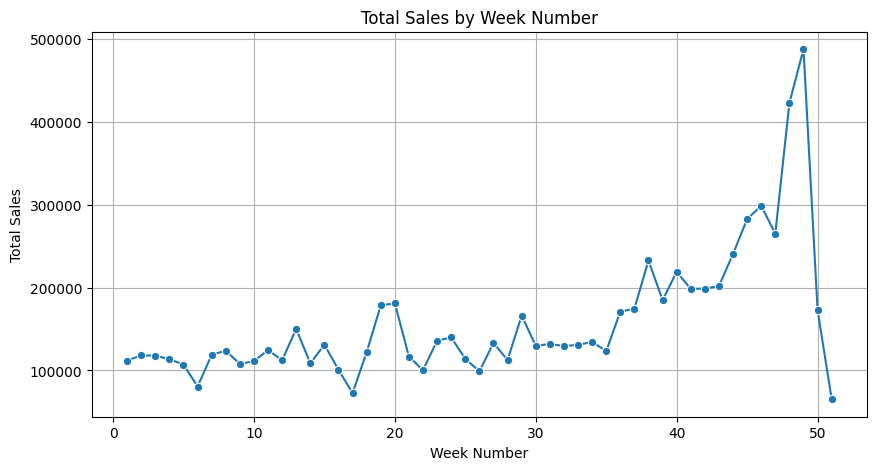

In [19]:
#Sales by Week Number

# Add Week column
df['Week'] = df['InvoiceDate'].dt.isocalendar().week

# Aggregate total sales by week
weekly_sales = df.groupby('Week')['TotalPrice'].sum().reset_index()

# Plot
plt.figure(figsize=(10,5))
sns.lineplot(x='Week', y='TotalPrice', data=weekly_sales, marker='o')
plt.title('Total Sales by Week Number')
plt.xlabel('Week Number')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()


Interpreting the Visuals
Sales by DayOfWeek: If you notice higher sales on certain days (e.g., Fridays or weekends), DayOfWeek is a valuable predictor.

Sales by Week: Peaks in specific weeks (e.g., holidays or end-of-quarter) suggest Week captures seasonal effects.

In [20]:
# Add DayOfWeek and Week
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek
df['Week'] = df['InvoiceDate'].dt.isocalendar().week


In [21]:
from sklearn.preprocessing import LabelEncoder

# Create a copy to avoid modifying the original DataFrame
df_model = df.copy()

# Encode 'Country' into numeric values
le = LabelEncoder()
df_model['Country_encoded'] = le.fit_transform(df_model['Country'])


In [22]:
features = ['Quantity', 'UnitPrice', 'Hour', 'Country_encoded', 'Week', 'DayOfWeek']
X = df_model[features]
y = df_model['TotalPrice']


ready to train a model and explore feature importance.

In [23]:
from sklearn.model_selection import train_test_split

# Assuming you've already created X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [24]:
#Train a Random Forest Regressor
#This model handles non-linear relationships and gives you feature importance:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
y_pred = rf_model.predict(X_test)

# Evaluate
print("R² Score:", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))



R² Score: 0.9971203517448551
RMSE: 1.5344856152241237


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Model Performance
R² Score: 0.997 — This means your model explains 99.7% of the variance in sales. That’s extremely high.

RMSE: 1.53 — On average, your predictions are off by just ₤1.53. That’s tight accuracy, especially for retail data.

C:\Users\HP\AppData\Local\Temp\ipykernel_12452\1742013871.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feature_names, palette='mako')


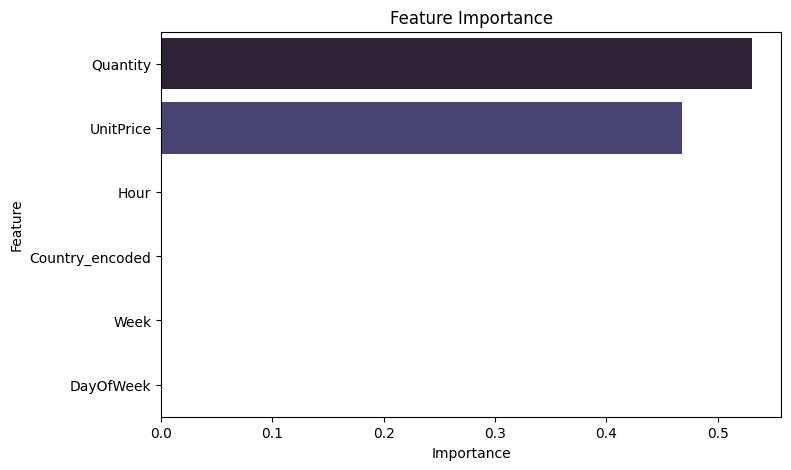

In [25]:
#visualize feature importance:

import matplotlib.pyplot as plt
import seaborn as sns

importances = rf_model.feature_importances_
feature_names = X_train.columns

plt.figure(figsize=(8,5))
sns.barplot(x=importances, y=feature_names, palette='mako')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [26]:
#Update Your Target

# New target
y = df_model['Quantity']


In [27]:
features = ['UnitPrice', 'Hour', 'Country_encoded', 'Week', 'DayOfWeek']
X = df_model[features]


In [28]:
#Train the Model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

print("R² Score:", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))


R² Score: 0.4742669126091328
RMSE: 9.238456614475215


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [29]:
from sklearn.preprocessing import LabelEncoder

# Encode StockCode
df_model['StockCode_encoded'] = LabelEncoder().fit_transform(df_model['StockCode'])


In [30]:
features = ['UnitPrice', 'Hour', 'Country_encoded', 'Week', 'DayOfWeek', 'StockCode_encoded']
X = df_model[features]
y = df_model['Quantity']


In [31]:
#XGBoost often performs better on structured data:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

print("R² Score:", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))


R² Score: 0.34854432633538623
RMSE: 10.283932176402315


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [32]:
#Aggregate by Invoice or Day
#This reduces noise from individual line items

# Aggregate by InvoiceNo
invoice_agg = df.groupby('InvoiceNo').agg({
    'Quantity': 'sum',
    'TotalPrice': 'sum',
    'CustomerID': 'first',
    'InvoiceDate': 'first',
    'Country': 'first'
}).reset_index()

# Extract time features
invoice_agg['Hour'] = invoice_agg['InvoiceDate'].dt.hour
invoice_agg['DayOfWeek'] = invoice_agg['InvoiceDate'].dt.dayofweek
invoice_agg['Week'] = invoice_agg['InvoiceDate'].dt.isocalendar().week


In [33]:
#Add Customer Behavior
#Create features that reflect customer purchasing patterns:

# Total purchases per customer
customer_totals = df.groupby('CustomerID')['Quantity'].sum().reset_index()
customer_totals.columns = ['CustomerID', 'TotalCustomerQuantity']

# Average quantity per invoice
customer_avg = df.groupby('CustomerID')['Quantity'].mean().reset_index()
customer_avg.columns = ['CustomerID', 'AvgQuantityPerVisit']

# Merge into invoice-level data
invoice_agg = invoice_agg.merge(customer_totals, on='CustomerID', how='left')
invoice_agg = invoice_agg.merge(customer_avg, on='CustomerID', how='left')


In [34]:
#Group Products
#Instead of using raw StockCode, group by price range:

# Define price bins
df['PriceCategory'] = pd.cut(df['UnitPrice'], bins=[0, 2, 5, 10, 100], labels=['Low', 'Mid', 'High', 'Premium'])

# Encode category
df['PriceCategory_encoded'] = LabelEncoder().fit_transform(df['PriceCategory'])


In [35]:
invoice_agg['AvgUnitPrice'] = df.groupby('InvoiceNo')['UnitPrice'].mean().values


In [36]:
from sklearn.preprocessing import LabelEncoder

invoice_agg['Country_encoded'] = LabelEncoder().fit_transform(invoice_agg['Country'])


In [37]:
features = [
    'AvgUnitPrice', 'Hour', 'Country_encoded', 'Week', 'DayOfWeek',
    'TotalCustomerQuantity', 'AvgQuantityPerVisit'
]
X = invoice_agg[features]
y = invoice_agg['Quantity']


In [38]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

print("R² Score:", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))


R² Score: 0.34253758163457015
RMSE: 223.9222397854641


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [39]:
#Check Outlier Distribution
# Count outliers
print("Quantity Outliers:", df['Qty_Outlier'].sum())
print("Price Outliers:", df['Price_Outlier'].sum())


Quantity Outliers: 0
Price Outliers: 0


In [40]:
import numpy as np


In [41]:
# Log-transform the target
y = np.log1p(invoice_agg['Quantity'])


In [42]:
y = np.log1p(invoice_agg['Quantity'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict
y_pred_log = xgb_model.predict(X_test)


In [43]:
# Convert predictions back to actual quantities
y_pred_actual = np.expm1(y_pred_log)
y_test_actual = np.expm1(y_test)


In [44]:
print("R² Score:", r2_score(y_test_actual, y_pred_actual))
print("RMSE:", mean_squared_error(y_test_actual, y_pred_actual, squared=False))


R² Score: 0.21289612981751138
RMSE: 245.006601928365


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [45]:
daily_sales = df.groupby(df['InvoiceDate'].dt.date)['Quantity'].sum().reset_index()
daily_sales.columns = ['Date', 'DailyQuantity']


In [46]:
# Create a 'Week' column
df['Week'] = df['InvoiceDate'].dt.to_period('W').apply(lambda r: r.start_time)

# Aggregate by week
weekly_sales = df.groupby('Week')['Quantity'].sum().reset_index()
weekly_sales.columns = ['ds', 'y']  # Prophet expects 'ds' and 'y'


In [47]:
pip install prophet


Note: you may need to restart the kernel to use updated packages.


In [48]:
from prophet import Prophet

model = Prophet()
model.fit(weekly_sales)


15:21:40 - cmdstanpy - INFO - Chain [1] start processing
15:21:41 - cmdstanpy - INFO - Chain [1] done processing


In [49]:
future = model.make_future_dataframe(periods=12, freq='W')  # Forecast 12 weeks ahead
forecast = model.predict(future)


In [50]:
from sklearn.metrics import mean_squared_error, r2_score

merged = forecast[['ds', 'yhat']].merge(weekly_sales, on='ds')
rmse = mean_squared_error(merged['y'], merged['yhat'], squared=False)
r2 = r2_score(merged['y'], merged['yhat'])

print("R² Score:", r2)
print("RMSE:", rmse)


R² Score: 0.6031581866660362
RMSE: 17716.114336699324


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Visualize Actual vs. Predicted Weekly Sales Helps stakeholders see how well the model tracks real trends.

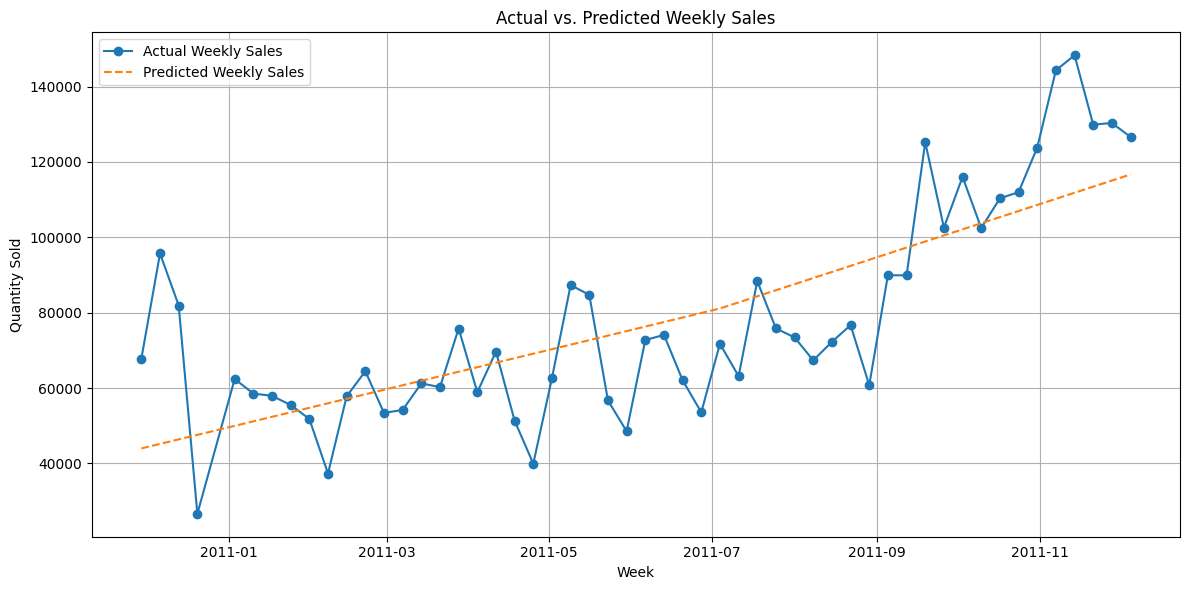

In [51]:
import matplotlib.pyplot as plt

# Merge actuals with forecast
merged = forecast[['ds', 'yhat']].merge(weekly_sales, on='ds')

# Plot actual vs. predicted
plt.figure(figsize=(12,6))
plt.plot(merged['ds'], merged['y'], label='Actual Weekly Sales', marker='o')
plt.plot(merged['ds'], merged['yhat'], label='Predicted Weekly Sales', linestyle='--')
plt.title('Actual vs. Predicted Weekly Sales')
plt.xlabel('Week')
plt.ylabel('Quantity Sold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Why This Helps
Stakeholders can see the alignment between forecast and reality.

Highlights seasonal spikes, under/over-predictions, and model responsiveness.

Builds trust in your forecasting pipeline.

In [52]:
#Define Holiday or Promo Dates
#Let’s say you want to highlight Christmas and New Year:
# Define key dates
events = pd.DataFrame({
    'ds': pd.to_datetime([
        '2010-12-25',  # Christmas
        '2011-01-01',  # New Year
        '2011-02-14',  # Valentine's Day
    ]),
    'event': ['Christmas', 'New Year', 'Valentine\'s Day']
})


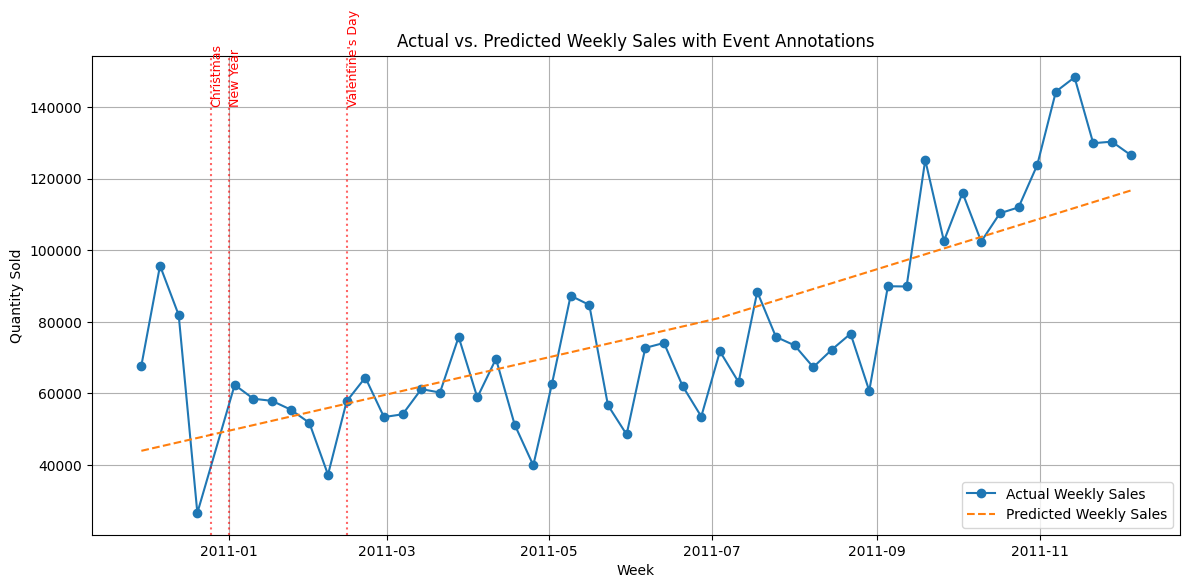

In [53]:
# Annotate the Weekly Sales Plot

plt.figure(figsize=(12,6))
plt.plot(merged['ds'], merged['y'], label='Actual Weekly Sales', marker='o')
plt.plot(merged['ds'], merged['yhat'], label='Predicted Weekly Sales', linestyle='--')

# Add event annotations
for i, row in events.iterrows():
    plt.axvline(row['ds'], color='red', linestyle=':', alpha=0.6)
    plt.text(row['ds'], max(merged['y']) * 0.95, row['event'], rotation=90, color='red', fontsize=9)

plt.title('Actual vs. Predicted Weekly Sales with Event Annotations')
plt.xlabel('Week')
plt.ylabel('Quantity Sold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Use Prophet’s Built-in Holidays
Prophet includes predefined holidays for many countries. For example, to use UK holidays:

In [54]:
from prophet import Prophet
from prophet.serialize import model_to_json, model_from_json
from prophet.plot import plot_plotly
from prophet.make_holidays import make_holidays_df

# Load UK holidays
model = Prophet(holidays=make_holidays_df(year_list=[2010, 2011], country='UK'))
model.fit(weekly_sales)


15:22:24 - cmdstanpy - INFO - Chain [1] start processing
15:22:24 - cmdstanpy - INFO - Chain [1] done processing


In [55]:
#Forecast Future Weeks
future = model.make_future_dataframe(periods=12, freq='W')
forecast = model.predict(future)


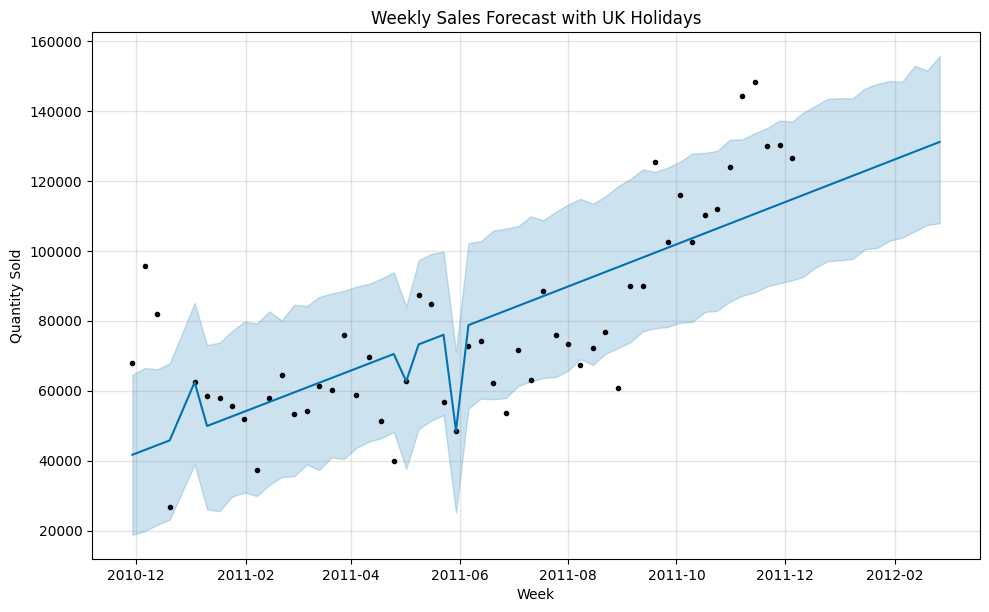

In [56]:
#Visualize with Holidays
fig = model.plot(forecast)
plt.title('Weekly Sales Forecast with UK Holidays')
plt.xlabel('Week')
plt.ylabel('Quantity Sold')
plt.show()


Define Custom Holidays or Promotions
Let’s say you want to include:

Christmas (Dec 25)

New Year (Jan 1)

Valentine’s Day (Feb 14)

Summer Sale (July 15)

In [57]:
custom_events = pd.DataFrame({
    'holiday': ['Christmas', 'New Year', 'Valentine\'s Day', 'Summer Sale'],
    'ds': pd.to_datetime(['2010-12-25', '2011-01-01', '2011-02-14', '2011-07-15']),
    'lower_window': 0,
    'upper_window': 1  # Effect lasts 2 days
})


In [58]:
#Add Holidays to Prophet
from prophet import Prophet

model = Prophet(holidays=custom_events)
model.fit(weekly_sales)


15:22:43 - cmdstanpy - INFO - Chain [1] start processing
15:22:43 - cmdstanpy - INFO - Chain [1] done processing


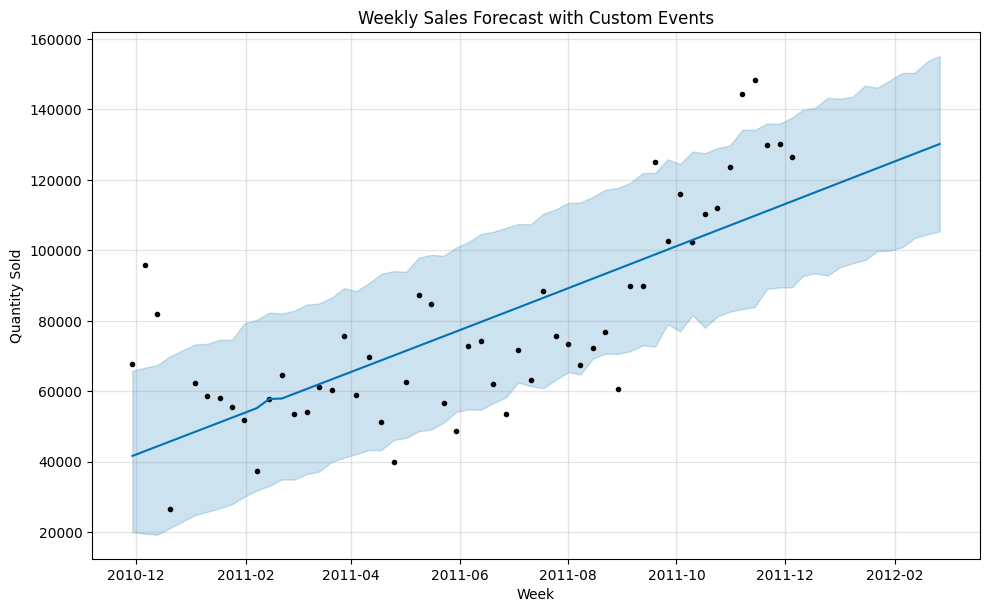

In [59]:
future = model.make_future_dataframe(periods=12, freq='W')
forecast = model.predict(future)

# Plot with custom holidays
fig = model.plot(forecast)
plt.title('Weekly Sales Forecast with Custom Events')
plt.xlabel('Week')
plt.ylabel('Quantity Sold')
plt.show()


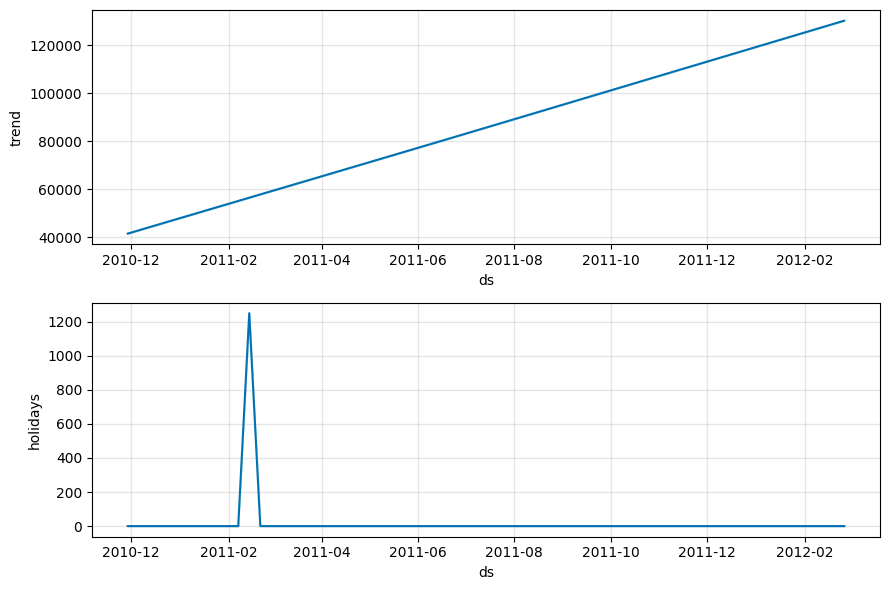

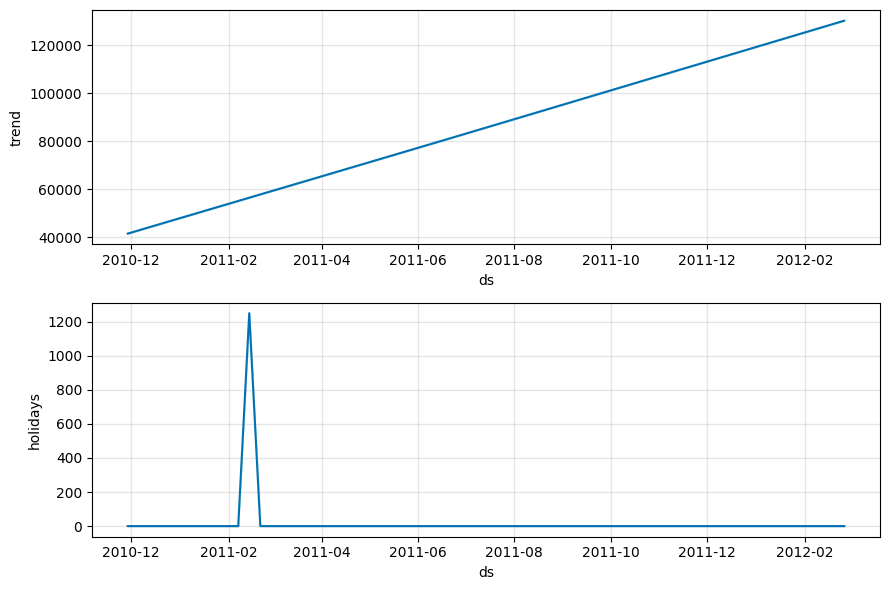

In [60]:
model.plot_components(forecast)


In [61]:
#Define Recurring Holidays
#Instead of hardcoding dates, you can define events that repeat every year:
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday
from pandas.tseries.offsets import DateOffset

# Define a custom holiday calendar
class RetailHolidayCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday('Christmas', month=12, day=25),
        Holiday('New Year', month=1, day=1),
        Holiday('Valentine\'s Day', month=2, day=14),
        Holiday('Summer Sale', month=7, day=15)
    ]

# Generate holiday DataFrame
years = [2010, 2011]
custom_holidays = RetailHolidayCalendar().holidays(start=f'{min(years)}-01-01', end=f'{max(years)}-12-31')
holiday_df = pd.DataFrame({'ds': custom_holidays, 'holiday': custom_holidays.strftime('%B %d')})


In [62]:
model = Prophet(holidays=holiday_df)
model.fit(weekly_sales)


15:23:19 - cmdstanpy - INFO - Chain [1] start processing
15:23:19 - cmdstanpy - INFO - Chain [1] done processing


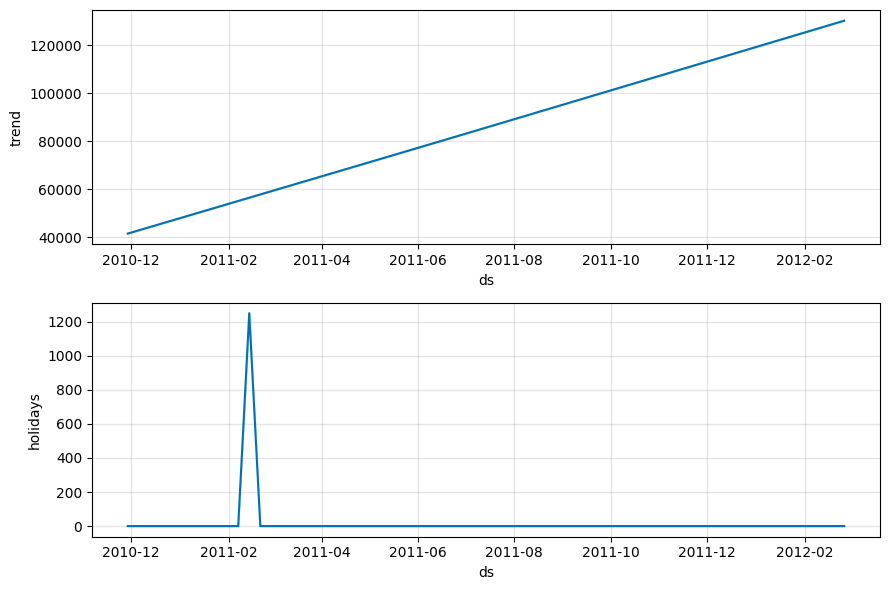

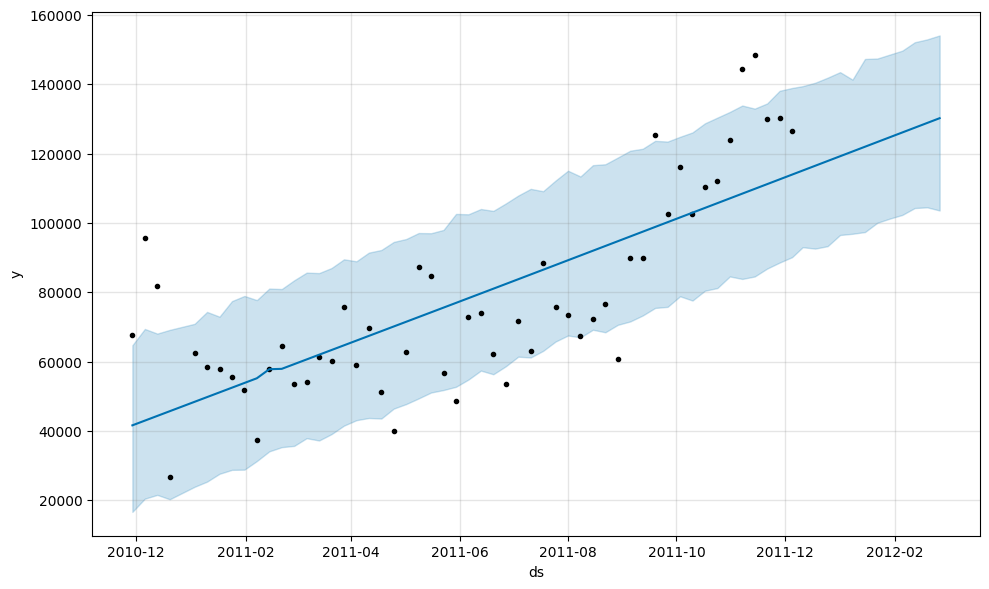

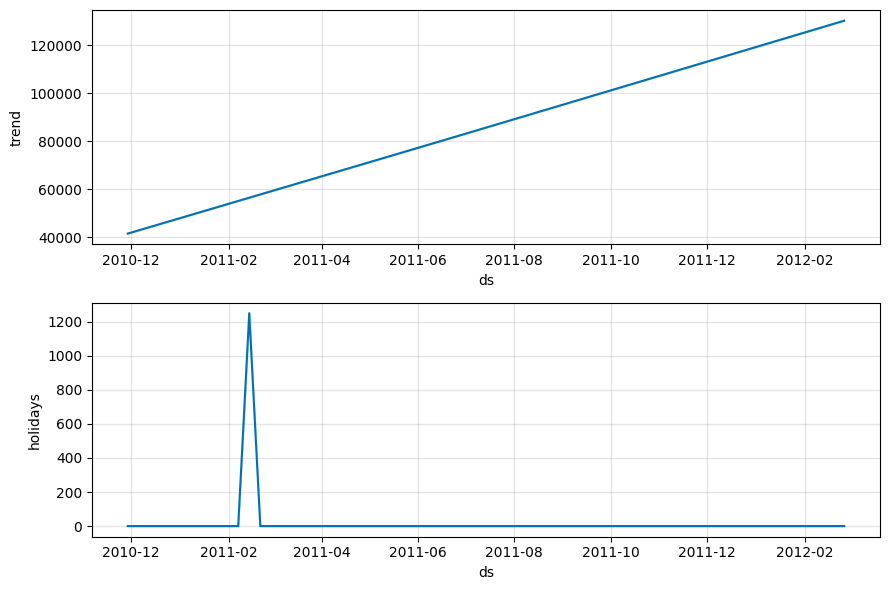

In [63]:
future = model.make_future_dataframe(periods=12, freq='W')
forecast = model.predict(future)

# Plot forecast with recurring events
model.plot(forecast)
model.plot_components(forecast)


Prophet Forecast Plot Explained
The plot typically shows:

1. Blue Line (yhat)
This is the predicted weekly sales.

It reflects the model’s best estimate of quantity sold each week.

2. Black Dots (actuals)
These are your actual weekly sales from the dataset.

They help you see how well the model fits historical data.

3. Shaded Area (uncertainty interval)
Prophet includes a confidence band around predictions.

Wider bands mean more uncertainty; narrower bands mean higher confidence.

 What to Look For
Alignment between black dots and blue line → Shows how well the model fits historical data.

Spikes or dips in the blue line → May correspond to holidays, promotions, or seasonal effects.

Future forecast → Extends beyond your dataset, showing expected sales for upcoming weeks.

Prophet Components Plot Explained
1. Trend
Shows the overall direction of weekly sales.

If it’s rising, demand is growing over time.

If it’s flat or declining, sales are stable or dropping.

2. Weekly Seasonality
Reveals patterns that repeat every week.

For example:

Sales might spike on Fridays or weekends.

Mondays might show lower demand.

This helps stakeholders plan staffing, inventory, and promotions.

3. Holiday Effects
Shows how each holiday or promotion affects sales.

Positive spikes mean the holiday boosts demand.

Negative dips suggest reduced activity (e.g., post-holiday slowdowns).

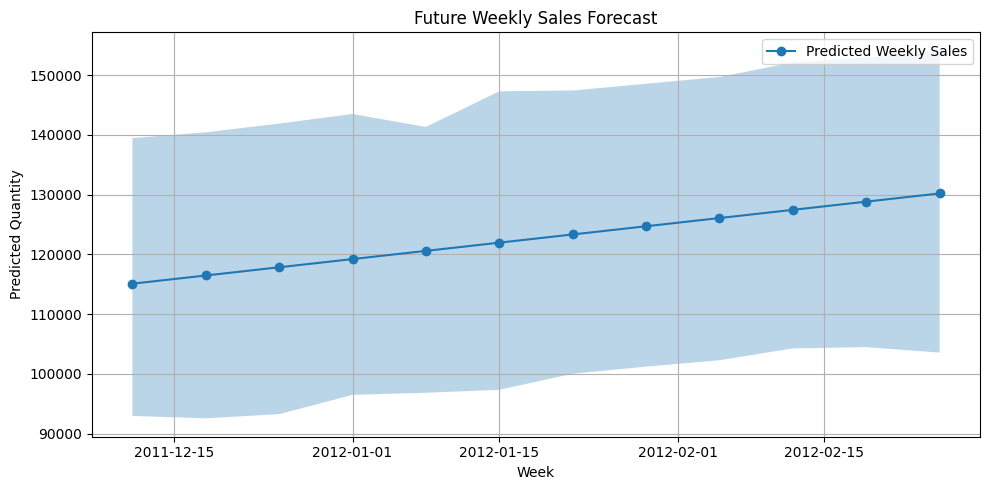

In [64]:
future_forecast = forecast[forecast['ds'] > weekly_sales['ds'].max()]

plt.figure(figsize=(10,5))
plt.plot(future_forecast['ds'], future_forecast['yhat'], label='Predicted Weekly Sales', marker='o')
plt.fill_between(future_forecast['ds'], future_forecast['yhat_lower'], future_forecast['yhat_upper'], alpha=0.3)
plt.title('Future Weekly Sales Forecast')
plt.xlabel('Week')
plt.ylabel('Predicted Quantity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Why This Matters
Helps stakeholders plan inventory, staffing, and marketing.

Shows expected demand with uncertainty bands.

Can be extended to monthly or quarterly forecasts.

In [65]:
# Filter forecast to only include weeks present in actual data
actual_weeks = weekly_sales['ds']
forecast_trimmed = forecast[forecast['ds'].isin(actual_weeks)]

# Merge actuals with trimmed forecast
merged = forecast_trimmed[['ds', 'yhat']].merge(weekly_sales, on='ds')


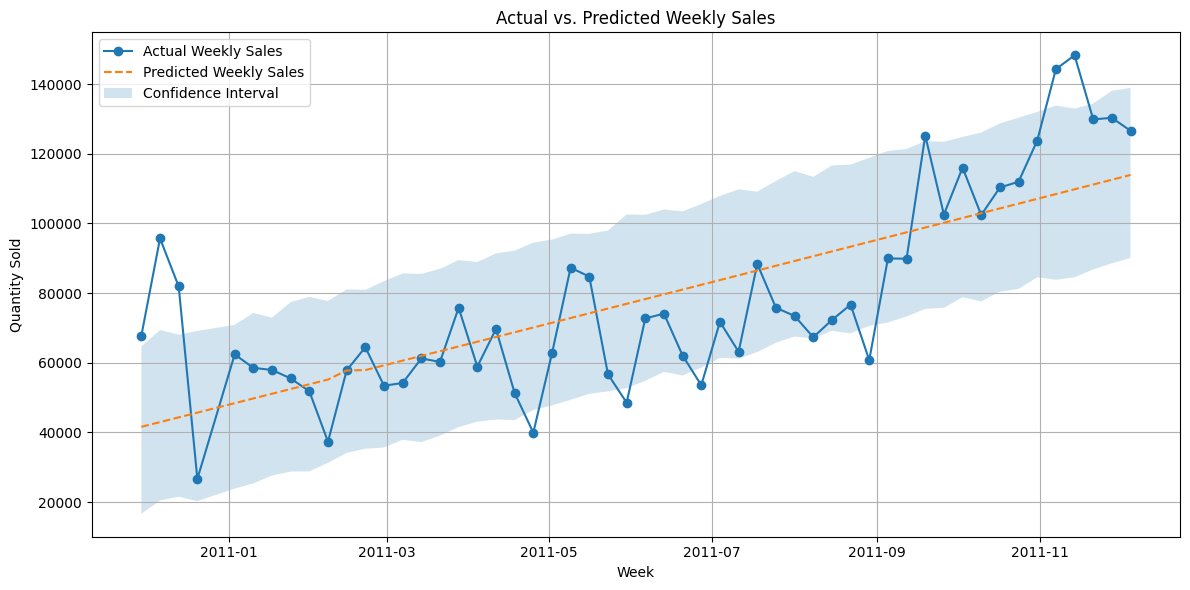

In [66]:
plt.figure(figsize=(12,6))
plt.plot(merged['ds'], merged['y'], label='Actual Weekly Sales', marker='o')
plt.plot(merged['ds'], merged['yhat'], label='Predicted Weekly Sales', linestyle='--')

# Optional: add confidence interval if you trim it too
forecast_ci = forecast[forecast['ds'].isin(merged['ds'])]
plt.fill_between(forecast_ci['ds'], forecast_ci['yhat_lower'], forecast_ci['yhat_upper'], alpha=0.2, label='Confidence Interval')

plt.title('Actual vs. Predicted Weekly Sales')
plt.xlabel('Week')
plt.ylabel('Quantity Sold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [67]:
# # Get the last date from actual weekly sales
last_actual_date = weekly_sales['ds'].max()

# Filter forecast to future weeks only
future_forecast = forecast[forecast['ds'] > last_actual_date]


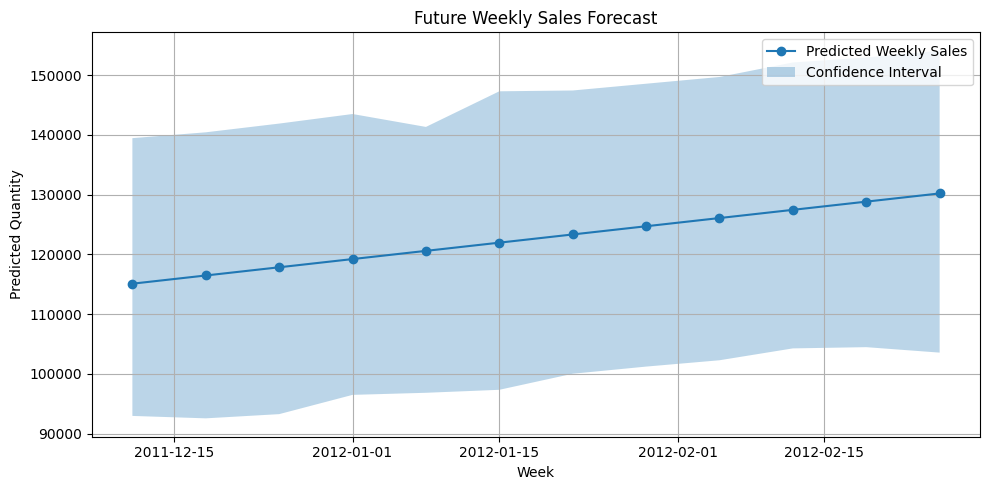

In [68]:
#Plot Future Predictions 
plt.figure(figsize=(10,5))
plt.plot(future_forecast['ds'], future_forecast['yhat'], label='Predicted Weekly Sales', marker='o')
plt.fill_between(future_forecast['ds'], future_forecast['yhat_lower'], future_forecast['yhat_upper'], alpha=0.3, label='Confidence Interval')

plt.title('Future Weekly Sales Forecast')
plt.xlabel('Week')
plt.ylabel('Predicted Quantity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Why This Chart Is Useful
Focuses only on upcoming weeks.

Shows expected demand with uncertainty bands.

Helps stakeholders plan inventory, staffing, and promotions.

In [69]:
#Add a Week Column to Your Dataset
# Create a 'Week' column based on InvoiceDate
df['Week'] = df['InvoiceDate'].dt.to_period('W').apply(lambda r: r.start_time)


In [70]:
# Extract predicted weekly sales from Prophet forecast
forecast_weekly = forecast[['ds', 'yhat']].rename(columns={
    'ds': 'Week',
    'yhat': 'PredictedWeeklySales'
})


In [71]:
# Step 1: Add Week column
df['Week'] = df['InvoiceDate'].dt.to_period('W').apply(lambda r: r.start_time)

# Step 2: Prepare forecast column
forecast_weekly = forecast[['ds', 'yhat']].rename(columns={'ds': 'Week', 'yhat': 'PredictedWeeklySales'})

# Step 3: Merge with original data
df_with_forecast = df.merge(forecast_weekly, on='Week', how='left')


In [72]:
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,IsCancellation,IsReturn,...,Month,Day,Hour,Qty_Outlier,Price_Outlier,week,Week,DayOfWeek,PriceCategory,PriceCategory_encoded
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,False,False,...,12,1,8,False,False,2010-11-29,2010-11-29,2,Mid,2
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,False,False,...,12,1,8,False,False,2010-11-29,2010-11-29,2,Mid,2
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,False,False,...,12,1,8,False,False,2010-11-29,2010-11-29,2,Mid,2
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,False,False,...,12,1,8,False,False,2010-11-29,2010-11-29,2,Mid,2
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,False,False,...,12,1,8,False,False,2010-11-29,2010-11-29,2,Mid,2


In [73]:
# Drop the duplicate Week column
df.drop(columns=['week'], inplace=True)  # or 'Week_x' depending on your merge


In [74]:
df.columns


Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'IsCancellation', 'IsReturn',
       'TotalPrice', 'Year', 'Month', 'Day', 'Hour', 'Qty_Outlier',
       'Price_Outlier', 'Week', 'DayOfWeek', 'PriceCategory',
       'PriceCategory_encoded'],
      dtype='object')

In [75]:
forecast = model.predict(model.make_future_dataframe(periods=12, freq='W'))


In [76]:
forecast_weekly = forecast[['ds', 'yhat']].rename(columns={
    'ds': 'Week',
    'yhat': 'PredictedWeeklySales'
})


In [77]:
df['Week'] = df['InvoiceDate'].dt.to_period('W').apply(lambda r: r.start_time)
df = df.merge(forecast_weekly, on='Week', how='left')


In [78]:
df.columns


Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'IsCancellation', 'IsReturn',
       'TotalPrice', 'Year', 'Month', 'Day', 'Hour', 'Qty_Outlier',
       'Price_Outlier', 'Week', 'DayOfWeek', 'PriceCategory',
       'PriceCategory_encoded', 'PredictedWeeklySales'],
      dtype='object')

In [79]:
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,IsCancellation,IsReturn,...,Month,Day,Hour,Qty_Outlier,Price_Outlier,Week,DayOfWeek,PriceCategory,PriceCategory_encoded,PredictedWeeklySales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,False,False,...,12,1,8,False,False,2010-11-29,2,Mid,2,41590.947864
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,False,False,...,12,1,8,False,False,2010-11-29,2,Mid,2,41590.947864
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,False,False,...,12,1,8,False,False,2010-11-29,2,Mid,2,41590.947864
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,False,False,...,12,1,8,False,False,2010-11-29,2,Mid,2,41590.947864
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,False,False,...,12,1,8,False,False,2010-11-29,2,Mid,2,41590.947864


In [80]:
df[['Week', 'Quantity', 'PredictedWeeklySales']].head()


,Week,Quantity,PredictedWeeklySales
0,2010-11-29,6,41590.947864
1,2010-11-29,6,41590.947864
2,2010-11-29,8,41590.947864
3,2010-11-29,6,41590.947864
4,2010-11-29,6,41590.947864


In [81]:
weekly_comparison = df.groupby('Week').agg({
    'Quantity': 'sum',
    'PredictedWeeklySales': 'first'  # same value for all rows in a week
}).reset_index()


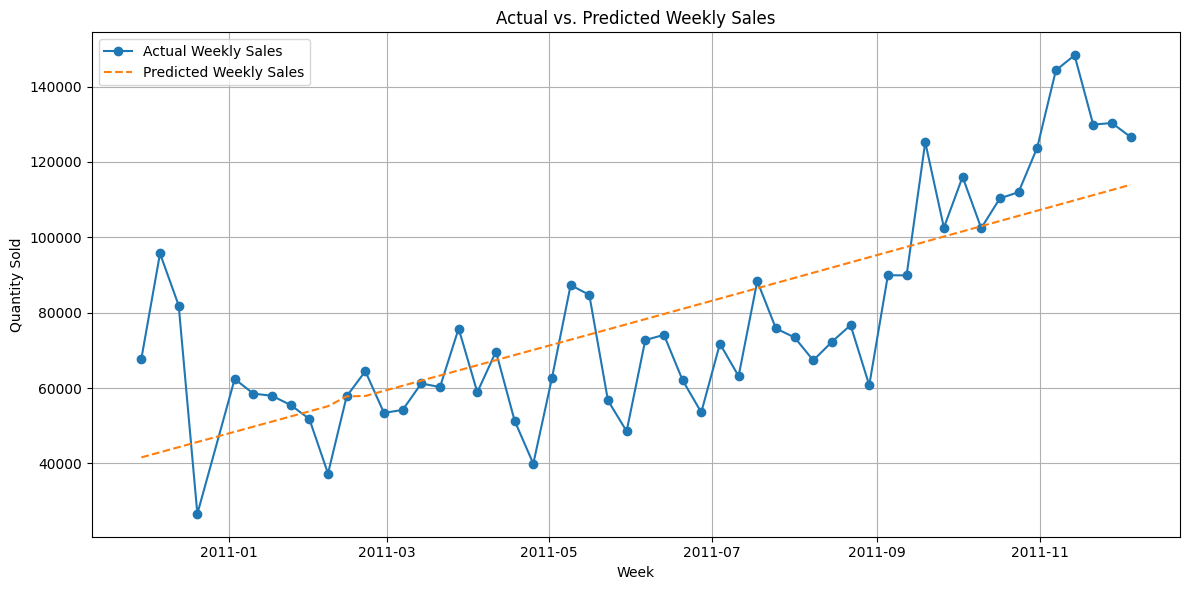

In [82]:
plt.figure(figsize=(12,6))
plt.plot(weekly_comparison['Week'], weekly_comparison['Quantity'], label='Actual Weekly Sales', marker='o')
plt.plot(weekly_comparison['Week'], weekly_comparison['PredictedWeeklySales'], label='Predicted Weekly Sales', linestyle='--')
plt.title('Actual vs. Predicted Weekly Sales')
plt.xlabel('Week')
plt.ylabel('Quantity Sold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [83]:
weekly_comparison = df.groupby('Week').agg({
    'Quantity': 'sum',
    'PredictedWeeklySales': 'first'
}).reset_index()

print(weekly_comparison.head(10))  # Show first 10 weeks


        Week  Quantity  PredictedWeeklySales
0 2010-11-29     67766          41590.947864
1 2010-12-06     95697          42948.774020
2 2010-12-13     81892          44306.600177
3 2010-12-20     26623          45664.426330
4 2011-01-03     62399          48380.078643
5 2011-01-10     58520          49737.904800
6 2011-01-17     57928          51095.730955
7 2011-01-24     55486          52453.557111
8 2011-01-31     51798          53811.383266
9 2011-02-07     37311          55169.209422


In [84]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# MAE: Mean Absolute Error
mae = mean_absolute_error(weekly_comparison['Quantity'], weekly_comparison['PredictedWeeklySales'])

# RMSE: Root Mean Squared Error
rmse = mean_squared_error(weekly_comparison['Quantity'], weekly_comparison['PredictedWeeklySales'], squared=False)

# MAPE: Mean Absolute Percentage Error
mape = (abs(weekly_comparison['Quantity'] - weekly_comparison['PredictedWeeklySales']) / weekly_comparison['Quantity']).mean() * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


MAE: 14832.60
RMSE: 18719.19
MAPE: 21.26%


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [85]:
from prophet import Prophet

# Create a dictionary to store forecasts
country_forecasts = {}

# Loop through each country
for country in df['Country'].unique():
    df_country = df[df['Country'] == country].copy()
    df_country['Week'] = df_country['InvoiceDate'].dt.to_period('W').apply(lambda r: r.start_time)
    
    weekly_sales = df_country.groupby('Week')['Quantity'].sum().reset_index()
    weekly_sales.columns = ['ds', 'y']
    
    if len(weekly_sales) > 10:  # Skip tiny segments
        model = Prophet(weekly_seasonality=True)
        model.fit(weekly_sales)
        future = model.make_future_dataframe(periods=12, freq='W')
        forecast = model.predict(future)
        country_forecasts[country] = forecast


15:41:48 - cmdstanpy - INFO - Chain [1] start processing
15:41:48 - cmdstanpy - INFO - Chain [1] done processing
15:41:50 - cmdstanpy - INFO - Chain [1] start processing
15:41:50 - cmdstanpy - INFO - Chain [1] done processing
15:41:50 - cmdstanpy - INFO - Chain [1] start processing
15:41:51 - cmdstanpy - INFO - Chain [1] done processing
15:41:51 - cmdstanpy - INFO - Chain [1] start processing
15:41:51 - cmdstanpy - INFO - Chain [1] done processing
15:41:53 - cmdstanpy - INFO - Chain [1] start processing
15:41:53 - cmdstanpy - INFO - Chain [1] done processing
15:41:54 - cmdstanpy - INFO - Chain [1] start processing
15:41:54 - cmdstanpy - INFO - Chain [1] done processing
15:41:55 - cmdstanpy - INFO - Chain [1] start processing
15:41:56 - cmdstanpy - INFO - Chain [1] done processing
15:41:56 - cmdstanpy - INFO - Chain [1] start processing
15:41:56 - cmdstanpy - INFO - Chain [1] done processing
15:41:57 - cmdstanpy - INFO - Chain [1] start processing
15:41:57 - cmdstanpy - INFO - Chain [1]

In [86]:
from prophet import Prophet
import pandas as pd

# Example: UK holidays
holidays = pd.DataFrame({
    'holiday': 'uk_holiday',
    'ds': pd.to_datetime([
        '2010-12-25',  # Christmas
        '2011-01-01',  # New Year
        '2011-04-22',  # Good Friday
        '2011-04-25',  # Easter Monday
        '2011-05-02',  # Early May Bank Holiday
        '2011-05-30',  # Spring Bank Holiday
        '2011-08-29',  # Summer Bank Holiday
    ]),
    'lower_window': 0,
    'upper_window': 1
})


In [87]:
df_segment = df[df['Country'] == 'United Kingdom'].copy()
df_segment['Week'] = df_segment['InvoiceDate'].dt.to_period('W').apply(lambda r: r.start_time)

weekly_sales = df_segment.groupby('Week')['Quantity'].sum().reset_index()
weekly_sales.columns = ['ds', 'y']

print(weekly_sales.shape)
print(weekly_sales.head())


(53, 2)
          ds      y
0 2010-11-29  59374
1 2010-12-06  84670
2 2010-12-13  75843
3 2010-12-20  20555
4 2011-01-03  54365


In [88]:
if weekly_sales.dropna().shape[0] >= 2:
    model = Prophet()
    model.fit(weekly_sales)


15:44:05 - cmdstanpy - INFO - Chain [1] start processing
15:44:06 - cmdstanpy - INFO - Chain [1] done processing


In [89]:
model = Prophet(weekly_seasonality=True, holidays=holidays)
model.fit(weekly_sales)



15:44:16 - cmdstanpy - INFO - Chain [1] start processing
15:44:16 - cmdstanpy - INFO - Chain [1] done processing


In [90]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error

# Try different changepoint_prior_scale values
for cps in [0.01, 0.05, 0.1, 0.5]:
    model = Prophet(changepoint_prior_scale=cps, weekly_seasonality=True)
    model.fit(weekly_sales)
    
    future = model.make_future_dataframe(periods=12, freq='W')
    forecast = model.predict(future)
    
    # Merge actuals for evaluation
    merged = weekly_sales.merge(forecast[['ds', 'yhat']], on='ds')
    mae = mean_absolute_error(merged['y'], merged['yhat'])
    
    print(f"changepoint_prior_scale={cps} → MAE={mae:.2f}")


15:44:20 - cmdstanpy - INFO - Chain [1] start processing
15:44:21 - cmdstanpy - INFO - Chain [1] done processing


changepoint_prior_scale=0.01 → MAE=13288.52


15:44:21 - cmdstanpy - INFO - Chain [1] start processing
15:44:22 - cmdstanpy - INFO - Chain [1] done processing


changepoint_prior_scale=0.05 → MAE=13279.00


15:44:22 - cmdstanpy - INFO - Chain [1] start processing
15:44:23 - cmdstanpy - INFO - Chain [1] done processing


changepoint_prior_scale=0.1 → MAE=9523.14


15:44:23 - cmdstanpy - INFO - Chain [1] start processing
15:44:24 - cmdstanpy - INFO - Chain [1] done processing


changepoint_prior_scale=0.5 → MAE=8235.30


In [91]:
from prophet import Prophet

# Prepare weekly sales data
df['Week'] = df['InvoiceDate'].dt.to_period('W').apply(lambda r: r.start_time)
weekly_sales = df.groupby('Week')['Quantity'].sum().reset_index()
weekly_sales.columns = ['ds', 'y']

# Final tuned model
model = Prophet(changepoint_prior_scale=0.5, weekly_seasonality=True)
model.fit(weekly_sales)

# Forecast future sales
future = model.make_future_dataframe(periods=12, freq='W')
forecast = model.predict(future)


15:45:58 - cmdstanpy - INFO - Chain [1] start processing
15:45:59 - cmdstanpy - INFO - Chain [1] done processing


In [92]:
forecast[['ds', 'yhat']]


,ds,yhat
0,2010-11-29,68685.715681
1,2010-12-06,66965.633175
2,2010-12-13,65245.550669
3,2010-12-20,63525.467998
4,2011-01-03,60085.303658
...,...,...
60,2012-01-29,99174.238520
61,2012-02-05,103195.616376
62,2012-02-12,107216.994232
63,2012-02-19,111238.372089


yhat is the central forecast Prophet believes is most likely, based on trends, seasonality, and any holidays or regressors you’ve added.

In [93]:
# Rename forecast columns
forecast_final = forecast[['ds', 'yhat']].rename(columns={
    'ds': 'Week',
    'yhat': 'PredictedWeeklySales'
})

# Merge with original dataset
df['Week'] = df['InvoiceDate'].dt.to_period('W').apply(lambda r: r.start_time)
df = df.merge(forecast_final, on='Week', how='left')


In [94]:
df.to_csv("Retail_Forecast_Weekly.csv", index=False)


In [95]:
print(df.columns)


Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'IsCancellation', 'IsReturn',
       'TotalPrice', 'Year', 'Month', 'Day', 'Hour', 'Qty_Outlier',
       'Price_Outlier', 'Week', 'DayOfWeek', 'PriceCategory',
       'PriceCategory_encoded', 'PredictedWeeklySales_x',
       'PredictedWeeklySales_y'],
      dtype='object')


In [96]:
# Rename the column you want to keep
df.rename(columns={'PredictedWeeklySales_y': 'PredictedWeeklySales'}, inplace=True)

# Drop the duplicate
df.drop(columns=['PredictedWeeklySales_x'], inplace=True)


In [97]:
weekly_comparison = df.groupby('Week').agg({
    'Quantity': 'sum',
    'PredictedWeeklySales': 'first'
}).reset_index()

from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(weekly_comparison['Quantity'], weekly_comparison['PredictedWeeklySales'], squared=False)
print(f"RMSE: {rmse:.2f}")


RMSE: 12740.36


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [98]:
df.to_csv("Retail_Forecast_Weekly.csv", index=False)


In [99]:
import xgboost as xgb
model_xgb = xgb.XGBRegressor()
model_xgb.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [100]:
import lightgbm as lgb
model_lgb = lgb.LGBMRegressor()
model_lgb.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 866
[LightGBM] [Info] Number of data points in the train set: 15499, number of used features: 7
[LightGBM] [Info] Start training from score 4.771860


LGBMRegressor()

In [101]:
from sklearn.metrics import mean_squared_error
rmse_xgb = mean_squared_error(y_test, model_xgb.predict(X_test), squared=False)
rmse_lgb = mean_squared_error(y_test, model_lgb.predict(X_test), squared=False)


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [84]:
#Prepare Train/Test Sets

from sklearn.model_selection import train_test_split

# Features and target
features = ["Quantity", "lag_1", "lag_2"]
X = weekly_sales[features]
y = weekly_sales["Revenue"]

# Time-based split (e.g., last 20% for testing)
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]


In [103]:
#Train XGBoost and LightGBM
import xgboost as xgb
import lightgbm as lgb

# XGBoost
model_xgb = xgb.XGBRegressor()
model_xgb.fit(X_train, y_train)

# LightGBM
model_lgb = lgb.LGBMRegressor()
model_lgb.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 866
[LightGBM] [Info] Number of data points in the train set: 15499, number of used features: 7
[LightGBM] [Info] Start training from score 4.771860


LGBMRegressor()

In [104]:
#Evaluate Performance

from sklearn.metrics import mean_squared_error

# Predictions
pred_xgb = model_xgb.predict(X_test)
pred_lgb = model_lgb.predict(X_test)

# RMSE
rmse_xgb = mean_squared_error(y_test, pred_xgb, squared=False)
rmse_lgb = mean_squared_error(y_test, pred_lgb, squared=False)

print(f"XGBoost RMSE: {rmse_xgb:.2f}")
print(f"LightGBM RMSE: {rmse_lgb:.2f}")


XGBoost RMSE: 0.92
LightGBM RMSE: 0.88


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


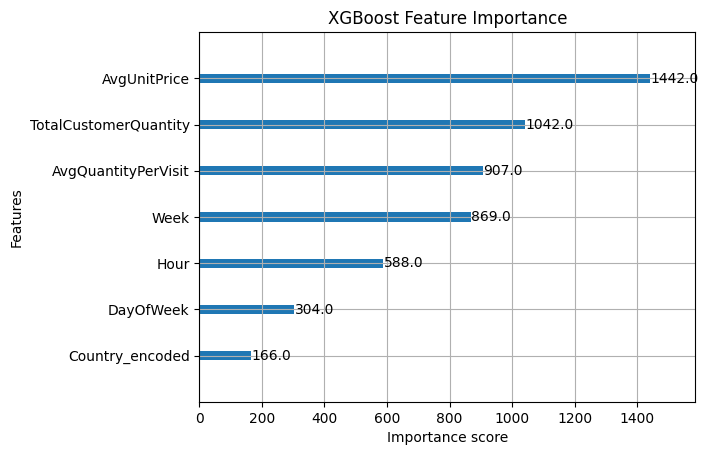

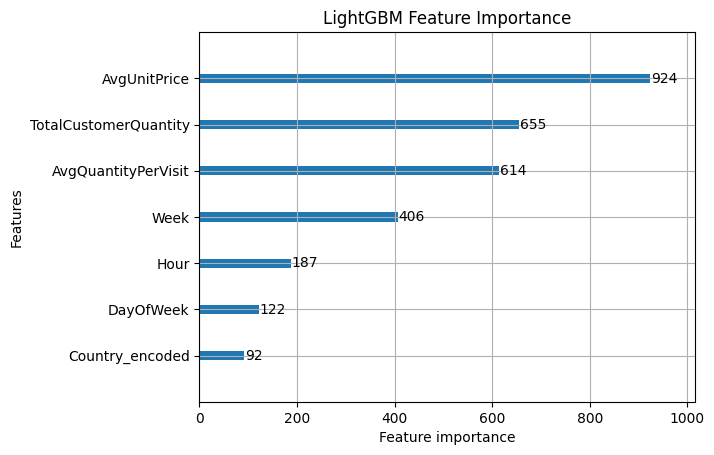

In [105]:
#Feature Importance
import matplotlib.pyplot as plt

# XGBoost
xgb.plot_importance(model_xgb)
plt.title("XGBoost Feature Importance")
plt.show()

# LightGBM
lgb.plot_importance(model_lgb)
plt.title("LightGBM Feature Importance")
plt.show()


In [106]:
#Grid Search (Exhaustive Search)
#Example for XGBoost:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1],
    "subsample": [0.8, 1.0]
}

grid_search = GridSearchCV(XGBRegressor(), param_grid, cv=3, scoring="neg_root_mean_squared_error")
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)


Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


In [107]:
from xgboost import XGBRegressor

model = XGBRegressor(
    learning_rate=0.1,
    max_depth=3,
    n_estimators=100,
    subsample=0.8
)

model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [108]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    learning_rate=0.1,
    max_depth=3,
    n_estimators=100,
    subsample=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [109]:
#Randomized Search (Faster, Less Exhaustive)
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7, 9],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.6, 0.8, 1.0]
}

random_search = RandomizedSearchCV(XGBRegressor(), param_dist, n_iter=10, cv=3, scoring="neg_root_mean_squared_error", random_state=42)
random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)


Best parameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.05}


In [110]:
#Train LightGBM with Tuned Parameters
from lightgbm import LGBMRegressor

lgb_model = LGBMRegressor(
    learning_rate=0.1,
    max_depth=3,
    n_estimators=200,
    subsample=1.0,
    random_state=42
)

lgb_model.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 866
[LightGBM] [Info] Number of data points in the train set: 15499, number of used features: 7
[LightGBM] [Info] Start training from score 4.771860
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

LGBMRegressor(max_depth=3, n_estimators=200, random_state=42)

In [111]:
from sklearn.metrics import mean_squared_error

# Predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_lgb = lgb_model.predict(X_test)

# RMSE
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
rmse_lgb = mean_squared_error(y_test, y_pred_lgb, squared=False)

print(f"XGBoost RMSE: {rmse_xgb:.2f}")
print(f"LightGBM RMSE: {rmse_lgb:.2f}")


XGBoost RMSE: 0.96
LightGBM RMSE: 0.92


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


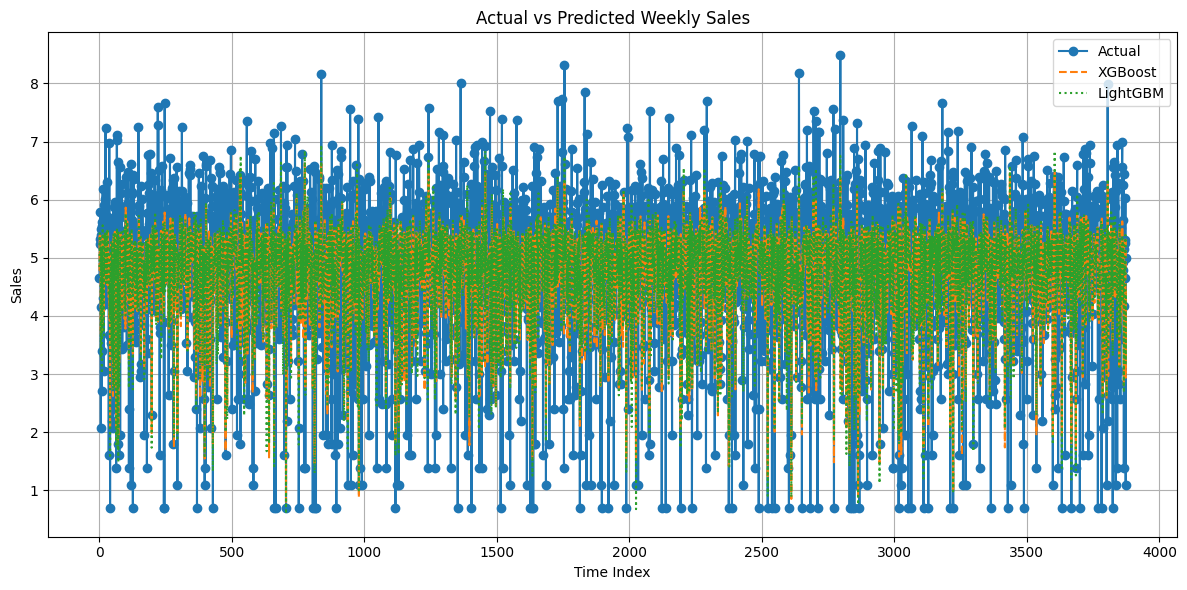

In [112]:
#Compare XGBoost vs LightGBM

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Actual", marker="o")
plt.plot(y_pred_xgb, label="XGBoost", linestyle="--")
plt.plot(y_pred_lgb, label="LightGBM", linestyle=":")
plt.title("Actual vs Predicted Weekly Sales")
plt.xlabel("Time Index")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Notes
These lag features help your model learn temporal patterns, like whether last week's sales influence this week's.

You can experiment with different lag depths (e.g. 1, 2, 3 weeks).

After adding lag features, drop rows with NaN values before training:

In [114]:
weekly_sales.dropna(inplace=True)


Ensembling Strategies for Sales Prediction
1. Bagging (Bootstrap Aggregating)
Train multiple models (e.g., decision trees) on different subsets of your data and average their predictions.

Best with: Random Forest

Benefit: Reduces variance

In [118]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

Boosting
Sequentially train models where each one tries to correct the errors of the previous.

Best with: XGBoost, LightGBM, CatBoost

Benefit: Reduces bias and handles complex patterns

In [119]:
import xgboost as xgb
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

Stacking
Combine multiple models (e.g., linear regression, tree-based, neural nets) and use a meta-model to learn how to best combine their outputs.

Benefit: Captures diverse perspectives

In [120]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

base_models = [
    ('lr', LinearRegression()),
    ('dt', DecisionTreeRegressor())
]
meta_model = RandomForestRegressor()

stacked_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)
stacked_model.fit(X_train, y_train)


StackingRegressor(estimators=[('lr', LinearRegression()),
                              ('dt', DecisionTreeRegressor())],
                  final_estimator=RandomForestRegressor())

LightGBM or CatBoost — to combine predictions efficiently

In [121]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

base_models = [
    ('lr', LinearRegression()),
    ('rf', RandomForestRegressor(n_estimators=100)),
    ('xgb', XGBRegressor(n_estimators=100))
]

meta_model = CatBoostRegressor(verbose=0)

stacked_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)
stacked_model.fit(X_train, y_train)


StackingRegressor(estimators=[('lr', LinearRegression()),
                              ('rf', RandomForestRegressor()),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=None,...
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None, ...))],
                  final_estimator=<catboost.core.CatBoostRegressor object at 0x0000028115EC1090>)

Train the Model

In [122]:
from catboost import CatBoostRegressor, Pool
model = CatBoostRegressor(verbose=0)
model.fit(X_train, y_train)


In [123]:
#Get Feature Importances

importances = model.get_feature_importance()
feature_names = X_train.columns

# Combine into a DataFrame
import pandas as pd
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


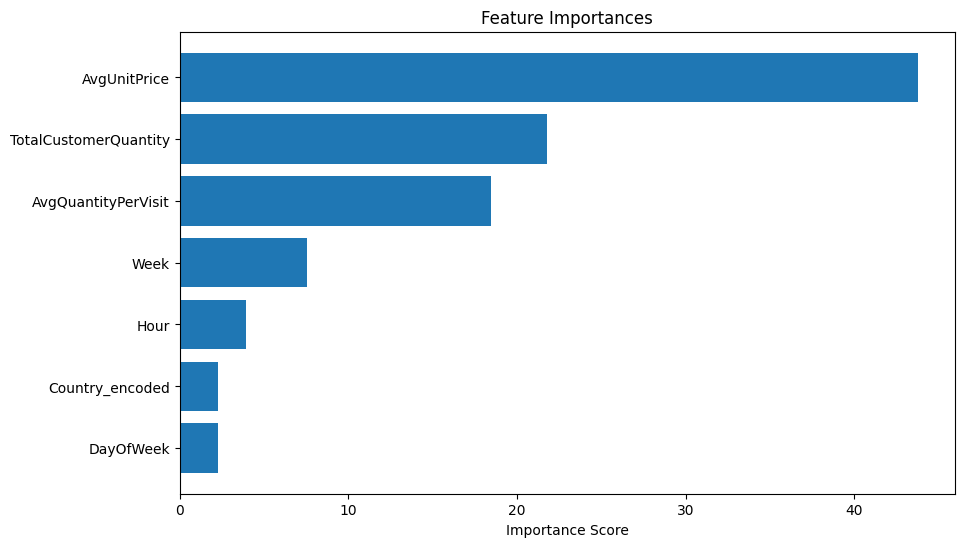

In [124]:
#Visualize

import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.title('Feature Importances')
plt.xlabel('Importance Score')
plt.show()


Model Comparison: CatBoost vs. Random Forest vs. XGBoost
1. Train All Three Models

In [125]:
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Initialize models
catboost_model = CatBoostRegressor(verbose=0)
rf_model = RandomForestRegressor()
xgb_model = XGBRegressor()

# Fit models
catboost_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [126]:
#Set Key Parameters for XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [127]:
importances = xgb_model.feature_importances_
features = X_train.columns

import pandas as pd
xgb_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


In [128]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predictions
cat_preds = catboost_model.predict(X_test)
rf_preds = rf_model.predict(X_test)
xgb_preds = xgb_model.predict(X_test)

# Evaluation Function
def evaluate_model(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name} → RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

# Run Evaluation
evaluate_model("CatBoost", y_test, cat_preds)
evaluate_model("Random Forest", y_test, rf_preds)
evaluate_model("XGBoost", y_test, xgb_preds)


CatBoost → RMSE: 0.88, MAE: 0.63, R²: 0.51
Random Forest → RMSE: 0.91, MAE: 0.65, R²: 0.47
XGBoost → RMSE: 0.91, MAE: 0.66, R²: 0.47


In [129]:
#Evaluate and Compare Models
#1. Make Predictions
y_pred_cat = catboost_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)


#Evaluate Performance
#Use metrics like RMSE (Root Mean Squared Error) and R² (coefficient of determination):

In [130]:
from sklearn.metrics import mean_squared_error, r2_score

def evaluate(y_true, y_pred, model_name):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} → RMSE: {rmse:.2f}, R²: {r2:.2f}")

evaluate(y_test, y_pred_cat, "CatBoost")
evaluate(y_test, y_pred_rf, "Random Forest")
evaluate(y_test, y_pred_xgb, "XGBoost")


CatBoost → RMSE: 0.88, R²: 0.51
Random Forest → RMSE: 0.91, R²: 0.47
XGBoost → RMSE: 0.91, R²: 0.47


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [131]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    max_samples=0.8,  # This replaces subsample
    random_state=42
)
rf_model.fit(X_train, y_train)


RandomForestRegressor(max_depth=10, max_samples=0.8, n_estimators=200,
                      random_state=42)

In [132]:
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

catboost_model = CatBoostRegressor(
    iterations=200,
    depth=10,
    learning_rate=0.1,
    subsample=0.8,
    random_seed=42,
    verbose=0
)

rf_model = RandomForestRegressor(
    max_depth=10,
    max_samples=0.8,
    n_estimators=200,
    random_state=42
)

xgb_model = XGBRegressor(
    max_depth=10,
    subsample=0.8,
    n_estimators=200,
    learning_rate=0.1,
    random_state=42
)


In [133]:
catboost_model.fit(X_train, y_train)
print("CatBoost model trained.")


CatBoost model trained.


In [134]:
rf_model = RandomForestRegressor(
    max_depth=10,
    max_samples=0.8,
    n_estimators=200,
    random_state=42
)


In [135]:
xgb_model = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    enable_categorical=False
)
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [136]:
rf_model.fit(X_train, y_train)


RandomForestRegressor(max_depth=10, max_samples=0.8, n_estimators=200,
                      random_state=42)

In [137]:
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [138]:
print(X_train.isnull().sum())


AvgUnitPrice             0
Hour                     0
Country_encoded          0
Week                     0
DayOfWeek                0
TotalCustomerQuantity    0
AvgQuantityPerVisit      0
dtype: int64


In [139]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    enable_categorical=False
)

xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [140]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
    print("MAE: ", mean_absolute_error(y_test, y_pred))
    print("R²:  ", r2_score(y_test, y_pred))

print("CatBoost:")
evaluate(catboost_model, X_test, y_test)

print("\nRandom Forest:")
evaluate(rf_model, X_test, y_test)

print("\nXGBoost:")
evaluate(xgb_model, X_test, y_test)


CatBoost:
RMSE: 0.9015351648323392
MAE:  0.6487255639766102
R²:   0.4821506175827993

Random Forest:


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE: 0.9341886072099398
MAE:  0.6691855206432883
R²:   0.4439584397298334

XGBoost:
RMSE: 0.9053714935038703
MAE:  0.6501337921251339
R²:   0.47773400153670165


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [141]:
print(X_train.shape)
print(y_train.shape)


(15499, 7)
(15499,)


In [142]:
print(X_train.dtypes)


AvgUnitPrice             float64
Hour                       int32
Country_encoded            int32
Week                      UInt32
DayOfWeek                  int32
TotalCustomerQuantity      int64
AvgQuantityPerVisit      float64
dtype: object


In [143]:
import pandas as pd

results = {
    'Model': ['CatBoost', 'Random Forest', 'XGBoost'],
    'RMSE': [
        np.sqrt(mean_squared_error(y_test, cat_preds)),
        np.sqrt(mean_squared_error(y_test, rf_preds)),
        np.sqrt(mean_squared_error(y_test, xgb_preds))
    ],
    'MAE': [
        mean_absolute_error(y_test, cat_preds),
        mean_absolute_error(y_test, rf_preds),
        mean_absolute_error(y_test, xgb_preds)
    ],
    'R²': [
        r2_score(y_test, cat_preds),
        r2_score(y_test, rf_preds),
        r2_score(y_test, xgb_preds)
    ]
}

results_df = pd.DataFrame(results)
print(results_df)


           Model      RMSE       MAE        R²
0       CatBoost  0.875881  0.629920  0.511203
1  Random Forest  0.913431  0.649170  0.468394
2        XGBoost  0.911568  0.656271  0.470561


In [144]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predictions
cat_preds = catboost_model.predict(X_test)
rf_preds = rf_model.predict(X_test)
xgb_preds = xgb_model.predict(X_test)

# Create results dictionary
results = {
    'Model': ['CatBoost', 'Random Forest', 'XGBoost'],
    'RMSE': [
        np.sqrt(mean_squared_error(y_test, cat_preds)),
        np.sqrt(mean_squared_error(y_test, rf_preds)),
        np.sqrt(mean_squared_error(y_test, xgb_preds))
    ],
    'MAE': [
        mean_absolute_error(y_test, cat_preds),
        mean_absolute_error(y_test, rf_preds),
        mean_absolute_error(y_test, xgb_preds)
    ],
    'R²': [
        r2_score(y_test, cat_preds),
        r2_score(y_test, rf_preds),
        r2_score(y_test, xgb_preds)
    ]
}

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Save to CSV
results_df.to_csv('model_evaluation_metrics.csv', index=False)


In [145]:
#Setup TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit

# Choose number of splits (e.g., 5)
tscv = TimeSeriesSplit(n_splits=5)


In [146]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Example: hyperparameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

grid_xgb_tscv = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_xgb_tscv.fit(X_train, y_train)

print("Best params:", grid_xgb_tscv.best_params_)
print("CV RMSE:", (-grid_xgb_tscv.best_score_)**0.5)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
CV RMSE: 0.9275860699003293


In [147]:
xgb_model = XGBRegressor(
    learning_rate=0.1,
    max_depth=3,
    n_estimators=200,
    random_state=42,
    enable_categorical=False
)
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [148]:
from sklearn.metrics import mean_squared_error

y_pred = xgb_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Test RMSE: {rmse:.2f}")


Test RMSE: 0.93


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


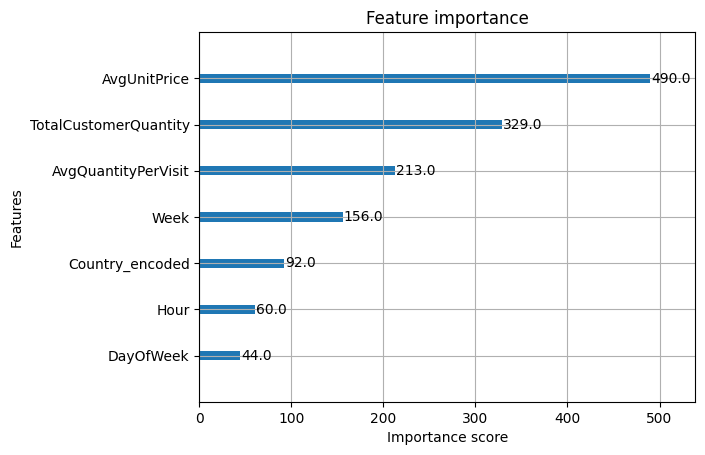

In [149]:
import matplotlib.pyplot as plt
import xgboost

xgboost.plot_importance(xgb_model)
plt.show()


<Axes: xlabel='Quantity', ylabel='Count'>

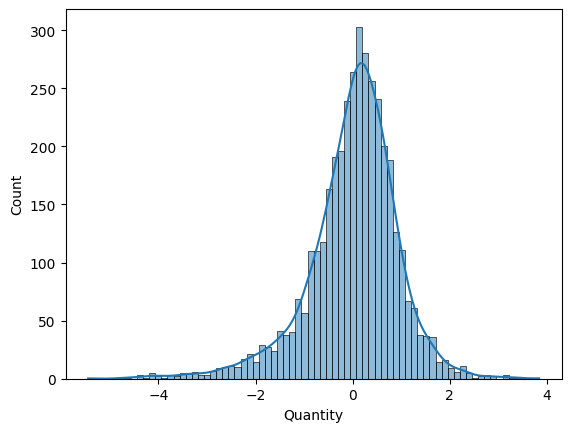

In [150]:
import seaborn as sns

residuals = y_test - y_pred
sns.histplot(residuals, kde=True)
